In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Imports


In [2]:
# append the path for the source code directory
import sys
import numpy as np
import pandas as pd

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

import scipy.sparse as sparse


import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for plots
sns.set_style("white")

sys.path.append("../src/visualization/edgebundling/")

from graphToDfUtility import graphToDfUtility
from graphReadingUtility import graphReadingUtility
from frLayoutUtility import frLayoutUtility
from addZCoordinate import ZCoordinateAdder
from pruneEdges import pruneEdges
from postBundlingUtility import postBundlingUtility
from nodesEdgesJsonSaver import nodesSaver, edgesSaver
from hammerBundling3D import hammer_bundle

# Define Paths


In [48]:
# 2. Constants and configuration
INPUT_GRAPH_PATH = "../data/07-clustered-graphs/alpha0.3_k10_res0.002.graphml"
CLUSTER_INFO_LABEL_TREE = "../output/cluster-qualifications/ClusterInfoLabelTree.xlsx"
CLUSTER_LABEL_DICT_PATH = "../data/99-testdata/cluster_label_dict.json"
CLUSTER_TREE_PATH = "../output/cluster-qualifications/ClusterHierachy_noComments.json"
OUTPUT_DIR = "../data/09-threeJs/"
THREEJS_OUTPUT_DIR = (
    "/Users/jlq293/Projects/Random Projects/LW-ThreeJS/2d_ssrinetworkviz/src/data/"
)
CLUSTER_HIERACHY_FOR_LEGEND_PATH = (
    "../output/cluster-qualifications/ClusterHierachy_noComments.json"
)


FR_GRAPH_FILENAME = "FR_Layout_Graph.graphml"

NODES_DATA_FILENAME = "TESTTESTTESTNodesData0to100_BundlPerc50_BW0,4.json"
EDGES_DATA_FILENAME = "TESTTESTTESTEdgesData0to100_BundlPerc50_BW0,4.json"

## read and layout the graph


In [4]:
g = graphReadingUtility.read_and_clean_graph(INPUT_GRAPH_PATH)

subgraph = True

if subgraph:

    cluster_list = list(range(99, 101))

    # subset to only cluster 0 to 100
    g = graphReadingUtility.subgraph_of_clusters(g, cluster_list)

    total_nodes = len(g.vs)
    print(f"Total nodes in the sub graph: {total_nodes}")
print("#" * 100)

################################################################################################
layout_params = {
    # "k": 0.5, # distance between nodes; best to leave it to algo
    "iterations": 50,  # (default=50) use 100
    "threshold": 0.0001,  # default 0.0001
    "weight": "weight",
    "scale": 5000,
    "center": (0, 0),
    "dim": 2,
    "seed": 1887,
}

g_fr, pos = frLayoutUtility.fr_layout_nx(g, layout_params)


print("#" * 100)


################################################################################################

# Add z-coordinate to nodes based on centrality
z_adder = ZCoordinateAdder(g_fr, percentage=20)
g_z = z_adder.add_z_coordinate_to_nodes()

print("#" * 100)

Node Attributes: ['doi', 'year', 'title', 'cluster', 'node_id', 'node_name', 'centrality']
Edge Attributes: ['weight', 'edge_id']
Number of nodes: 40643
Number of edges: 602779
Total nodes in the sub graph: 208
####################################################################################################
Starting Fruchterman-Reingold layout process...
Layout parameters: {'iterations': 50, 'threshold': 0.0001, 'weight': 'weight', 'scale': 5000, 'center': (0, 0), 'dim': 2, 'seed': 1887}
Converting to NetworkX Graph...
Conversion complete.
Graph has 208 nodes and 1188 edges.
Calculating layout...
Layout calculation completed in 0.08 seconds.
Processing layout results...
Layout boundaries:
X-axis: Min = -5000.00, Max = 4722.29
Y-axis: Min = -3278.12, Max = 4464.82
Assigning coordinates to nodes...
Layout process completed in 0.08 seconds.
####################################################################################################
Z Coordinates are added, based on their centra

/Users/jlq293/Projects/Study-1-Bibliometrics/notebooks/../src/visualization/edgebundling/graphReadingUtility.py:10: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  g = ig.Graph.Read_GraphML(path)


## save graph with x, y, z coordinates


In [5]:
# Assuming g_z is your NetworkX graph object

full_path = OUTPUT_DIR + FR_GRAPH_FILENAME

# Save as GraphML file
# nx.write_graphml(g_z, full_path)
print(f"Graph saved as GraphML: {full_path}")

# read back in
# g_z = nx.read_graphml(full_path)

Graph saved as GraphML: /Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/fr_0to100clusters.graphml


## Prune


In [6]:
################################################################################################
# Prune edges by weight percentile
percentile_to_keep = 0.25  # we keep 25 %
pruner = pruneEdges(
    g_z,
)
print("Pruning edges by weight percentile:")
g_pruned_weight = pruner.prune_edges_by_weight_percentile(percentile_to_keep)
summary = pruner.get_prune_summary()
print("Summary after pruning by weight:")
print(summary)

print("\n" + "#" * 80 + "\n")

# Prune random percentage of edges
percentile_to_keep = 0.25  # we keep 25 %
pruner = pruneEdges(
    g_z,
)
print("Pruning edges randomly:")
g_pruned_random = pruner.prune_edges_randomly(percentile_to_keep)
summary = pruner.get_prune_summary()
print("Summary after random pruning:")
print(summary)

print("#" * 100)

Pruning edges by weight percentile:
Weight Threshold: 0.67
Edges with this weight: 6
Kept top 25.0% of edges by weight
Edges kept: 301 out of 1188
Summary after pruning by weight:
{'initial_edge_count': 1188, 'final_edge_count': 301, 'initial_isolates': 0, 'final_isolates': 83}

################################################################################

Pruning edges randomly:
Kept 25.0% of edges randomly
Edges kept: 297 out of 1188
Summary after random pruning:
{'initial_edge_count': 1188, 'final_edge_count': 297, 'initial_isolates': 0, 'final_isolates': 20}
####################################################################################################


## Dataframe conversion


In [7]:
# Assume `g` is an igraph.Graph object and you have the utility class imported.
edges_df = graphToDfUtility.edges_to_dataframe(g_pruned_random)
# Create edge and node DataFrames
nodes_df = graphToDfUtility.nodes_to_dataframe(
    g_pruned_random, normalize_coordinates=False, drop_columns=["node_id", "node_name"]
)

# Merge edge and node positions
edge_df_with_source_target_coords = (
    graphToDfUtility.create_edge_df_with_source_target_coords(g_pruned_random)
)

edge_df_with_source_target_coords.head(2)

Segment length statistics:
Min: 6.48
Max: 2109.16
Mean: 818.73
Median: 748.19


,weight,edge_id,source,target,source_x,source_y,source_z,target_x,target_y,target_z,segment_length
0,0.658660,25368,3,6,-3080.115120,-1335.574730,537.489196,-2982.605268,-670.498425,99.577746,802.247532
1,0.680866,5624,0,7,-2671.668856,-1765.389967,1866.206337,-2297.623946,-1371.828786,707.707805,1279.421294


In [8]:
# get dictionary of segment length, 25th, 50th, 75th percentile
segment_length_dict = {
    "10th_percentile": edge_df_with_source_target_coords["segment_length"].quantile(
        0.10
    ),
    "25th_percentile": edge_df_with_source_target_coords["segment_length"].quantile(
        0.25
    ),
    "50th_percentile": edge_df_with_source_target_coords["segment_length"].median(),
    "75th_percentile": edge_df_with_source_target_coords["segment_length"].quantile(
        0.75
    ),
}
segment_length_dict

{'10th_percentile': 255.3218315767042,
 '25th_percentile': 447.8152475805376,
 '50th_percentile': 748.1908718857584,
 '75th_percentile': 1190.5577146944538}

## quick check


(208, 208)


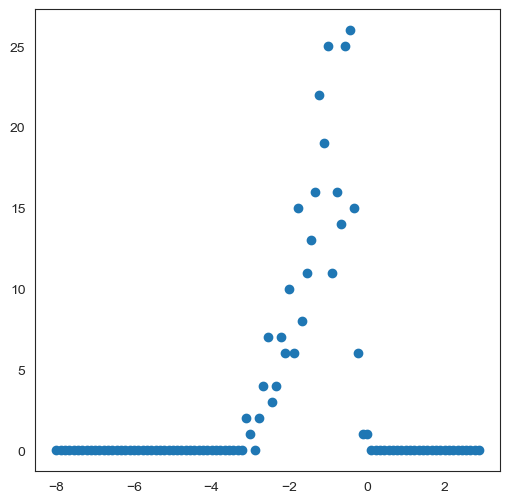

In [9]:
normalized_edge_df_with_source_target_coords = edge_df_with_source_target_coords.copy()
to_normalize = [
    "source_x",
    "source_y",
    "source_z",
    "target_x",
    "target_y",
    "target_z",
    "segment_length",
]
for col in to_normalize:
    normalized_edge_df_with_source_target_coords[col] = (
        graphToDfUtility.minmax_normalize(
            normalized_edge_df_with_source_target_coords[col]
        )
    )

Nnodes = nodes_df.shape[0]

subedges = (
    normalized_edge_df_with_source_target_coords["segment_length"]
    > normalized_edge_df_with_source_target_coords["segment_length"].median()
)

mat = sparse.coo_matrix(
    (
        np.ones(
            normalized_edge_df_with_source_target_coords.loc[subedges].shape[0],
            dtype=int,
        ),
        (
            normalized_edge_df_with_source_target_coords.loc[subedges, "source"].values,
            normalized_edge_df_with_source_target_coords.loc[subedges, "target"].values,
        ),
    ),
    shape=(Nnodes, Nnodes),
)

print(mat.shape)

ncomp, membership = sparse.csgraph.connected_components(mat)

mvalue, mcounts = np.unique(membership, return_counts=True)
mcounts, mcountdist = np.unique(mcounts, return_counts=True)

# mcounts, mcountdist

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

dist, bins = np.histogram(
    normalized_edge_df_with_source_target_coords["segment_length"].values,
    bins=np.exp(np.linspace(-8, 3, 100)),
)

ax.scatter(np.log(bins[:-1]), dist)

plt.show()

# BUNDLE


## Set Threshold for Edge Length


In [10]:
# get edges to bundle above a certain threshold
# threshold = 0.03
threshold = segment_length_dict["25th_percentile"]
edges_to_bundle = edge_df_with_source_target_coords["segment_length"] > threshold
edges_to_bundle_df = edge_df_with_source_target_coords.loc[edges_to_bundle].reset_index(
    drop=True
)
print(f"Total Nr of Pruned Edges: {len(edge_df_with_source_target_coords)}")
print(f"Edges to Bundle: {edges_to_bundle.sum()}")

Total Nr of Pruned Edges: 297
Edges to Bundle: 222


## Bundling


In [11]:
bundled_edge_pts = hammer_bundle(
    nodes_df[["x", "y", "z"]],
    edges_to_bundle_df[["source", "target"]],
    initial_bandwidth=0.05,
    decay=0.7,
    tension=0.3,
    accuracy=5 * 10**2,
    weight=None,
    advect_iterations=50,
    iterations=5,
    min_segment_length=0.01,
    max_segment_length=0.05,
)
bundled_edge_pts.head()

Process Bundling
Start Bundling


KeyboardInterrupt: 

## Post Bundling Processing

add source and target columns, create clean df and save it


In [36]:
# Example of how to use the class
edge_processor = postBundlingUtility(
    bundled_edge_pts, edges_to_bundle_df, edge_df_with_source_target_coords, threshold
)
final_edges_df = edge_processor.post_process_edges()

Number of bundled edges: 222
Number of total edges: 297
Number of straight edges: 75


# SAVER


In [63]:
e_saver = edgesSaver(final_edges_df, nodes_df)
edges_df_with_color = e_saver.add_color_attr()
edges_list = e_saver.transform_edges(
    extra_edge_attributes=["source", "target", "color"]
)

print("Example of an edge:")
print(edges_list[0])

# Save to JSON
e_saver.save_edges_to_json(edges_list, OUTPUT_DIR + EDGES_DATA_FILENAME)
e_saver.save_edges_to_json(
    edges_list,
    THREEJS_OUTPUT_DIR + EDGES_DATA_FILENAME,
)

Color attribute added to edges. 
-1 if inter-clusters, cluster number if intra-cluster edge.
Example of an edge:
{'source': 0, 'target': 11, 'color': 99, 'points': [{'x': -2671.6688558075, 'y': -1765.3899671381, 'z': 1866.2063373061}, {'x': -2677.2396190818, 'y': -1757.1960114377, 'z': 1819.4651092974}, {'x': -2680.7679688567, 'y': -1749.524370921, 'z': 1773.486645732}, {'x': -2681.7340991465, 'y': -1742.5347609295, 'z': 1727.9679588637}, {'x': -2680.8098748611, 'y': -1736.1939476868, 'z': 1683.1455606337}, {'x': -2679.1171698409, 'y': -1730.3074149004, 'z': 1640.2375065613}, {'x': -2677.5633558639, 'y': -1724.4329294576, 'z': 1599.8422974096}, {'x': -2676.6611262385, 'y': -1717.8262310234, 'z': 1560.6187813796}, {'x': -2676.8236122045, 'y': -1709.5913618931, 'z': 1520.4119397193}, {'x': -2678.657094979, 'y': -1699.386996779, 'z': 1478.426954074}, {'x': -2682.9501544325, 'y': -1688.7952357441, 'z': 1435.8574024834}, {'x': -2690.5602081574, 'y': -1682.6031979826, 'z': 1394.7906792769}, 

# save nodes


In [67]:
# save nodes
OUTPUT_DIRA = OUTPUT_DIR + NODES_DATA_FILENAME

OUTPUT_DIRB = THREEJS_OUTPUT_DIR + NODES_DATA_FILENAME

n_saver = nodesSaver()
nodes_json = n_saver.save_dataframe_nodes_to_json(
    nodes_df,
    paths=[OUTPUT_DIRA, OUTPUT_DIRB],
    return_json=True,
    attributes=[
        "doi",
        "year",
        "title",
        "cluster",
        "centrality",
        "x",
        "y",
        "z",
        "node_index",
    ],
)

print("Example of a node:")
nodes_json[0]

Graph nodes saved to /Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/TESTTESTTESTNodesData0to100_BundlPerc50_BW0,4.json
Graph nodes saved to /Users/jlq293/Projects/Random Projects/LW-ThreeJS/2d_ssrinetworkviz/src/data/TESTTESTTESTNodesData0to100_BundlPerc50_BW0,4.json
Example of a node:


{'doi': '10.1358/dof.1984.009.04.65213',
 'year': 1984,
 'title': 'Sertraline',
 'cluster': 99,
 'centrality': 0.959778863869367,
 'x': -2671.6688558075307,
 'y': -1765.38996713808,
 'z': 1866.2063373061153,
 'node_index': 0}

# Parameter Determination


In [17]:
import pandas as pd
import numpy as np
from itertools import product
import time
import os
import json

In [54]:
def explore_hammer_bundle_params(
    edges_df, nodes_df, params, num_runs=5, base_output_dir="output"
):
    """
    Explore different parameter combinations for the hammer_bundle algorithm,
    post-process results, and save outputs.

    Args:
    edges_df (pd.DataFrame): DataFrame containing edge information.
    nodes_df (pd.DataFrame): DataFrame containing node information.
    params (dict): Dictionary of parameter ranges to explore.
    num_runs (int): Number of parameter combinations to try.
    base_output_dir (str): Base directory for saving outputs.

    Returns:
    list: List of dictionaries containing results and file paths for each run.
    """
    global_start_time = time.time()

    all_combinations = list(
        product(
            params["min_edge_length_percentiles"],
            params["initial_bandwidth_values"],
            params["decay_values"],
            params["tension_values"],
            params["min_segment_length_values"],
        )
    )

    print(f"Nr of all possible combinations:", len(all_combinations))

    selected_combinations = np.random.choice(
        len(all_combinations), num_runs, replace=False
    )

    print(f"Selected Combinations:")
    for run in selected_combinations:
        print(all_combinations[run])

    results = []

    for i, combo_index in enumerate(selected_combinations):
        combo = all_combinations[combo_index]
        (
            min_edge_length_percentile,
            initial_bandwidth,
            decay,
            tension,
            min_segment_length,
        ) = combo

        print(f"\nRun {i+1}/{num_runs}")
        print(
            f"Parameters: \n min_edge_length_percentile={min_edge_length_percentile}\n initial_bandwidth={initial_bandwidth}\n decay={decay}\n tension={tension}\n min_segment_length={min_segment_length}"
        )

        # Create a unique identifier for this run
        run_id = f"run_{i+1}_perc{min_edge_length_percentile}_bw{initial_bandwidth}_d{decay}_t{tension}_msl{min_segment_length}"

        # Create output directory for this run
        run_output_dir = os.path.join(base_output_dir, run_id)
        os.makedirs(run_output_dir, exist_ok=True)

        # Calculate threshold and prepare edges for bundling
        threshold = np.percentile(
            edges_df["segment_length"], min_edge_length_percentile
        )
        edges_to_bundle = edges_df["segment_length"] > threshold
        edges_to_bundle_df = edges_df.loc[edges_to_bundle].reset_index(drop=True)

        print(f"Total Nr of Pruned Edges: {len(edges_df)}")
        print(f"Edges to Bundle: {edges_to_bundle.sum()}")

        start_time = time.time()

        try:
            # Run hammer_bundle
            bundled_edge_pts = hammer_bundle(
                nodes_df[["x", "y", "z"]],
                edges_to_bundle_df[["source", "target"]],
                initial_bandwidth=initial_bandwidth,
                decay=decay,
                tension=tension,
                accuracy=5 * 10**2,
                weight=None,
                advect_iterations=50,
                iterations=5,
                min_segment_length=min_segment_length,
                max_segment_length=0.05,
            )

            # Post-processing
            edge_processor = postBundlingUtility(
                bundled_edge_pts, edges_to_bundle_df, edges_df, threshold
            )
            final_edges_df = edge_processor.post_process_edges()

            edge_saver = edgesSaver(final_edges_df, nodes_df)
            edges_df_with_color = edge_saver.add_color_attr()
            edges_list = edge_saver.transform_edges(
                extra_edge_attributes=["source", "target", "color"]
            )
            # Save edges to JSON
            edges_filename = f"edges_{run_id}.json"
            edge_saver.save_edges_to_json(
                edges_list, os.path.join(run_output_dir, edges_filename)
            )
            # Save nodes to JSON
            nodes_filename = f"nodes_{run_id}.json"
            nodes_saver = nodesSaver()
            nodes_json = nodes_saver.save_dataframe_nodes_to_json(
                nodes_df,
                paths=[os.path.join(run_output_dir, nodes_filename)],
                return_json=True,
                attributes=[
                    "doi",
                    "year",
                    "title",
                    "cluster",
                    "centrality",
                    "x",
                    "y",
                    "z",
                    "node_index",
                ],
            )
            end_time = time.time()
            runtime = end_time - start_time
            results.append(
                {
                    "RUN": i + 1,
                    "run_id": run_id,
                    "parameters": {
                        "min_edge_length_percentile": min_edge_length_percentile,
                        "initial_bandwidth": initial_bandwidth,
                        "decay": decay,
                        "tension": tension,
                        "min_segment_length": min_segment_length,
                    },
                    "edges_bundled": int(edges_to_bundle.sum()),
                    "runtime": runtime,
                    "output_dir": run_output_dir,
                }
            )

            print(f"Run completed in {runtime:.2f} seconds")
            # print(f"Results saved in {run_output_dir}")

        except Exception as e:
            print(f"Error in run: {str(e)}")

    print(f"\nTotal time taken: {time.time() - global_start_time:.2f} seconds")
    results.append({"total_runtime": str(time.time() - global_start_time)})

    # Save summary of all runs
    summary_file = os.path.join(base_output_dir, "exploration_summary.json")
    with open(summary_file, "w") as f:
        json.dump(results, f, indent=2)

    return results

In [56]:
# Assuming edges_df and nodes_df are already defined
params = {
    "min_edge_length_percentiles": [15, 30],  #  [15],
    "initial_bandwidth_values": [0.025, 0.05, 0.10, 0.2],  #  [0.05],
    "decay_values": [0.75, 0.5, 0.25],  #  [0.5],
    "tension_values": [0.3, 0.1],  # [0.3],
    "min_segment_length_values": [0.01],
}

base_output_dir = OUTPUT_DIR + "ParamsFinding"

num_runs = 5

results = explore_hammer_bundle_params(
    edge_df_with_source_target_coords,
    nodes_df,
    params,
    num_runs=5,
    base_output_dir=base_output_dir,
)

Nr of all possible combinations: 48
Selected Combinations:
(30, 0.2, 0.75, 0.1, 0.01)
(30, 0.2, 0.25, 0.1, 0.01)
(30, 0.025, 0.25, 0.3, 0.01)
(15, 0.05, 0.5, 0.3, 0.01)
(30, 0.025, 0.75, 0.3, 0.01)

Run 1/5
Parameters: 
 min_edge_length_percentile=30
 initial_bandwidth=0.2
 decay=0.75
 tension=0.1
 min_segment_length=0.01
Total Nr of Pruned Edges: 297
Edges to Bundle: 208
Process Bundling
Start Bundling


In [50]:
results

[{'run_id': 'run_1_perc15_bw0.05_d0.5_t0.3_msl0.01',
  'parameters': {'min_edge_length_percentile': 15,
   'initial_bandwidth': 0.05,
   'decay': 0.5,
   'tension': 0.3,
   'min_segment_length': 0.01},
  'edges_bundled': 252,
  'runtime': 38.985087156295776,
  'output_dir': '../data/09-threeJs/ParamsFinding/run_1_perc15_bw0.05_d0.5_t0.3_msl0.01'},
 {'total_runtime': '38.98729872703552'}]